# MNIST clock

- L'objectif de ce notebook est de pouvoir afficher l'heure  à partir des chiffres du MNIST (Gif à la fin)

- Plus précisément à partir d'images générées par un GAN (Voir ci-dessous).

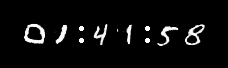

## *Importation des données*

In [ ]:
from IPython import display

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

import time
import os
import glob 
import imageio 
import cv2

- Traitement des données MNIST

In [ ]:
# On importe le dataset MNIST
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
# On met les valeurs à l'échelle [-1, 1] --> compatibilité 'tanh'
X = X_train.reshape(-1, 28, 28, 1).astype('float32')
X = (X - 127.5)/127.5

# On encode les labels en one-hot
y = tf.one_hot(y_train, 10)

batch_size = 256
dataset = tf.data.Dataset.from_tensor_slices((X, y))
dataset = dataset.shuffle(len(X)).batch(batch_size)

In [ ]:
for X_batch, y_batch in dataset:
  print('X_batch_shape:', X_batch.shape)
  print('y_batch_shape:', y_batch.shape)
  break

X_batch_shape: (256, 28, 28, 1)
y_batch_shape: (256, 10)


## Architecture des modèles

#### Le générateur

In [ ]:
def set_generator():
    noise_input = layers.Input(shape=(100), dtype='float32')
    class_input = layers.Input(shape=(10), dtype='float32')
    x = layers.concatenate([noise_input, class_input])

    x = layers.Dense(7*7*256, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((7, 7, 256))(x)

    x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
 
    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    output = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)
    model = models.Model(inputs=[noise_input, class_input], outputs=output)
    return model

#### Le discriminateur

In [ ]:
def set_discriminator():
    image_input = layers.Input(shape=(28, 28, 1), dtype='float32')
    class_input = layers.Input(shape=(10), dtype='float32')

    Z = layers.Dense(28*28, use_bias=False)(class_input)
    Z = layers.Reshape((28, 28, 1))(Z)
    x = layers.concatenate([image_input, Z])

    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Flatten()(x)
    output = layers.Dense(1)(x)
    model = models.Model(inputs=[image_input, class_input], outputs=output)
    return model

### Réglages des hyperparamètres

#### Initialisation des modèles

In [ ]:
generator = set_generator()
discriminator = set_discriminator()

- Optimiseurs

In [ ]:
# from_logits=True --> Pas de fonction d'activation pour le discriminateur
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
G_optimizer = tf.keras.optimizers.Adam(1E-4)
D_optimizer = tf.keras.optimizers.Adam(1E-4)

- Checkpoint

In [ ]:
checkpoint = tf.train.Checkpoint(G_optimizer=G_optimizer,
                                 D_optimizer=D_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

- Pertes du générateur et discriminateur

In [ ]:
# Les pertes du dicriminateur et du générateur doivent être considérées indépendemment.
def D_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def G_loss(fake_output):
    leaky_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return leaky_loss

#### Fonction train step

In [ ]:
@tf.function
def train_step(images, labels):
    # Bruit gaussien 
    noise = tf.random.normal([len(labels), noise_size])
    random_labels = tf.random.uniform(shape=[len(labels)], 
                                      minval=0, maxval=10, dtype=tf.dtypes.int32)
    # Les labels au format one_hot
    random_labels = tf.one_hot(random_labels, 10)

    # Un contexte pour chaque composant..
    with tf.GradientTape() as G_tape, tf.GradientTape() as D_tape:
      generated_images = generator([noise, random_labels], training=True)
      
      real_output = discriminator([images, labels], training=True)
      fake_output = discriminator([generated_images, random_labels], training=True)
 
      g_loss = G_loss(fake_output)
      d_loss = D_loss(real_output, fake_output)

    G_gradients = G_tape.gradient(g_loss, generator.trainable_variables)
    D_gradients = D_tape.gradient(d_loss, discriminator.trainable_variables)
    
    G_optimizer.apply_gradients(zip(G_gradients, generator.trainable_variables))
    D_optimizer.apply_gradients(zip(D_gradients, discriminator.trainable_variables))

## Phase d' entrainement

In [ ]:
shortcut = '/content/drive/MyDrive/HollowOak/GAN_Chess/'
generated_path = shortcut + 'MNIST/Generated/'
checkpoint_path = shortcut + 'MNIST/Check/'
gif_path = shortcut + 'MNIST/Gif/'
mnist_path = shortcut + 'MNIST/'
checkpoint_prefix = os.path.join(checkpoint_path, "ckpt")

#### Sauvegarde des images

In [ ]:
# Mosaique au format 6x6
mosaic_size = 6
num_samples = mosaic_size**2
noise_size = 100
# On définit un bruit gaussien fixé.
# Le même pour tout l'entrainement.
gaussian = tf.random.normal([num_samples, noise_size])

- Les images sont sauvegardées dans un format 'mosaique'

In [ ]:
# Mosaique 6x6 avec le même bruit aléatoire
def generate_and_save_mosaic(G_model, noise, epoch):
  labels = tf.one_hot(tf.range(num_samples)%10, 10)
  generated = G_model([noise, labels], training=False)
  mosaic = np.empty(shape=(mosaic_size*28, mosaic_size*28), dtype=np.float32)
  for i in range(mosaic_size):
    for j in range(mosaic_size):
      mosaic[j*28:(j+1)*28, i*28:(i+1)*28] = generated[j*mosaic_size+i, :, :, 0]*127.5 + 127.5
  cv2.imwrite('{}image_{:04d}.png'.format(generated_path, epoch), mosaic) 

#### Entrainement...et sauvegarde

In [ ]:
def train(dataset, epochs=500):
  start = time.time()
  for epoch in range(epochs):
    # Train step
    for images_batch, labels_batch in dataset:
      train_step(images_batch, labels_batch)
    generate_and_save_mosaic(generator, gaussian, epoch+1)
    # Enregistrement toutes les 50 époques
    if not (epoch+1)%50:
      checkpoint.save(file_prefix=checkpoint_prefix)
      print('Epoch {}: {} s'.format(epoch+1, time.time()-start))
      start = time.time()

In [ ]:
train(dataset)

Epoch 50: 322.7039580345154 s
Epoch 100: 305.2326006889343 s
Epoch 150: 305.30530166625977 s
Epoch 200: 305.2748029232025 s
Epoch 250: 305.2889041900635 s
Epoch 300: 305.3104076385498 s
Epoch 350: 305.28720116615295 s
Epoch 400: 305.35938119888306 s
Epoch 450: 305.24201798439026 s
Epoch 500: 305.30798053741455 s


#### Affichage des premiers résultats

In [ ]:
# Sauvegarde des poids du générateur
generator.save_weights(mnist_path)

In [41]:
os.chdir(generated_path)
gif_mosaic = 'mosaique.gif'

# Mettre les images générées au format GIF
with imageio.get_writer(gif_mosaic, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames[:100:2]:
    image = imageio.imread(generated_path+filename)
    os.chdir(gif_path)
    writer.append_data(image)

- Gif correspondant aux premières images générées

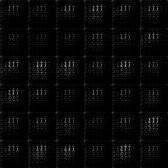

In [45]:
# Affichage mosaique dynamique
display.Image(open(gif_path+'mosaique.gif', 'rb').read())

## Utilisation du générateur

#### Construction horloge

In [46]:
# On importe le générateur entrainé
generator = set_generator()
generator.load_weights(mnist_path)

In [48]:
# O_clock génère de nouveaux chiffres pour afficher l'heure
class O_clock:
  def __init__(self, gap=20, inter=5):
    self.ref = [-1]*6
    self.clock = np.zeros((28+2*gap, 6*28+2*gap+4*inter), dtype=np.float32)
  
  def hour_to_mnist(self, hour, gap=20, inter=5):
    split = [int(i) for i in hour.replace(':', '')]
    labels = tf.one_hot(split, 10)
    gaussian = tf.random.normal([6, 100])
    generated = generator([gaussian, labels], training=False)
    generated = [img[..., 0]*127.5 + 127.5 for img in generated]
    for i, elt in enumerate(split):
      if elt != self.ref[i]:
        space = 2*int(i/2)*inter
        self.clock[gap:gap+28, gap+i*28+space:gap+(i+1)*28+space] = generated[i]
        self.ref[i] = elt
    for i, j in zip([2, 2, 4, 4], [8, 20, 8, 20]):
      cv2.circle(self.clock, (gap+i*28+(i-1)*inter, gap+j), 1, (255, 255, 255), 2)
    return self.clock.astype('uint8')

In [53]:
# On enregistre 100 secondes à la suite au format H-M-S
hours = []
for i in range(100):
  time.sleep(1.0)
  hours.append(time.strftime('%H:%M:%S'))

In [54]:
# On génère les 100 images correspondantes
ock = O_clock()
frames = [ock.hour_to_mnist(hour) for hour in hours]

#### Génération d'heures

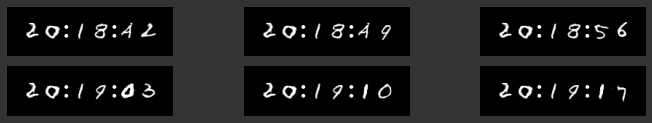

In [55]:
fig = plt.figure(figsize=(12, 2))
for i in range(6):
  plt.subplot(2, 3, i+1)
  fig.patch.set_facecolor('0.2')
  plt.axis('off')
  plt.imshow(255-frames[5 + 7*i], cmap='binary')

#### Gif horloge

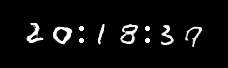

In [56]:
name = "final.gif"
kargs = { 'duration': 1 }
imageio.mimsave(gif_path+name, frames, 'GIF', **kargs)
display.Image(open(gif_path+name, 'rb').read())

- *Fin du notebook*